# Initial thoughts

Why would we need such data? Having in mind the Kopernikus' area of reseach and development, this dataset could be used for object detection, objects 3D bbox estimation, semantic segmentation, motion planning. For all of these applications, the annotated dataset is required. So, in the end, it's highly likely, that these images will be manually or semi-manually annotated.
Removing similar frames could be reqired to:
* maintain the greater data diversity
* reducing the cost of labelling

So, it's necessary to formulate what similarity means in this setting of stationary cameras observing parking lots:
* frames from different cameras can be assumed being non-similar, if we can gurantee the correcness of cameras ids. This assumption allows us to exclude the cross-camera similarity checking
* the scenes contain the parking lots. And usually not much happens in parking lots. That means, subsequent frames are highly likely to be similar. This fact plus the knowledge about the frames time order could be used for optimizations
* it could be, that the scene eventually becomes similar to what it was in the beginning of the series. For example, the parking lot is completely empty in the morning, and after busy day of cars arriving and departuring, it becomes emply again. That means, it's not enough to just remove subsequent similar frames. We need to check other image pairs as well.

# Suggested image comparison score analysis

Suggested function for image comparison takes a pair of images and produces some score value. The higher values of the score means less similar images.

The comparison function is commutative against the compared images. That means, the score could be used as metric. There are only two important things this function should have:
* The score should be comparable between images with different resoultions. Also, scores from different image sequences should be compared if we don't want to tune the parameters of the algorithm for each camera
* The triangle property should be held. If two elemetns are close to each other according to the score, and first is far from the third element, it must be, that this third element is also far from the second.

I would take it for granted that the second property is held. 

But the first one requires some processing applied to the score.
The raw output value represents the sum of contour areas in the binarized absolute difference between the images. So, this score for one images resolution is not comparable with the score for another image resolution, because the areas of the contours depend on in the area of the image. So, it's reasonable to normalize the raw score by the area of compared images thus having the score in range [0, 1]

In total, the algorithm has 2 parametrs: size of the gaussian blur kernel for preprocessing and minimal area of countour to take into account in the image comparison. Values of these parameters are subjects to find.

# Dataset analysis

1. There are different image resolutions inside certain camera sequences as well as comparing sequences
2. Different aspect ratios
3. Colorful and grayscale images (night mode). Colorful night mode images are processed by camera to increase sharpness and denoising which leads to blureness of non-border regions, higher level of noise and echoing of the borders
4. Corrupted files - necessary to exclude (not possible to read image or small size image)
5. Frames aren't equally spaced in time. There are some breaks varying from hours to days and months.
6. 4 different cameras - 5 different sequences


# Let's explore the data

In [2]:
DATASET_ROOT_DIR = '/Users/aleksandrrybnikov/Downloads/interview_challenge_per/dataset'

In [7]:
import sys  
sys.path.insert(1, './..')

from similar_frames_remover.annotation import create_annotation

annotation = create_annotation(DATASET_ROOT_DIR)

print(annotation.keys())
print(f'Total number of valid images: {sum([len(l) for _, l in annotation.items()])}')

dict_keys(['c23', 'c20', 'c21', 'c10'])
Total number of valid images: 1078


In [9]:
%matplotlib inline
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.dates as mdates

def plot_annnotations_timestamps(annotations, num_ticks=150, title=''):
    plt.cla()
    plt.clf()

    plt.tight_layout()

    # for cam_id, img_annotations in annotation.items():
        # dts = [datetime.fromtimestamp(a.epoch_timestamp_ms / 1000) for a in img_annotations]
        # dates.extend(dts)

    dates = [datetime.fromtimestamp(a.epoch_timestamp_ms / 1000) for a in annotations]

    start_date, end_date = min(dates), max(dates)
    total_num_minutes = int((end_date - start_date).total_seconds() / 60)
    tick_interval_mins = total_num_minutes // num_ticks
    print('Start date:', start_date)
    print('End date:', end_date)

    plt.plot(dates, np.zeros_like(dates), "-o",
            color="k", markerfacecolor="r")

    axes = plt.gca()
    axes.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval_mins))
    axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y_%m_%d__%H_%M'))
    axes.set_xlim(start_date - timedelta(minutes=tick_interval_mins), end_date + timedelta(minutes=tick_interval_mins))
    _ = plt.setp(axes.get_xticklabels(), rotation=80, ha="right")

    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False,
        labelright=False)

    plt.gcf().set_dpi(300)
    plt.gcf().set_figwidth(100)
    plt.grid(True, axis='x')
    plt.title(title)

Start date: 2021-06-16 21:18:18.865000
End date: 2021-06-17 09:15:19.849000


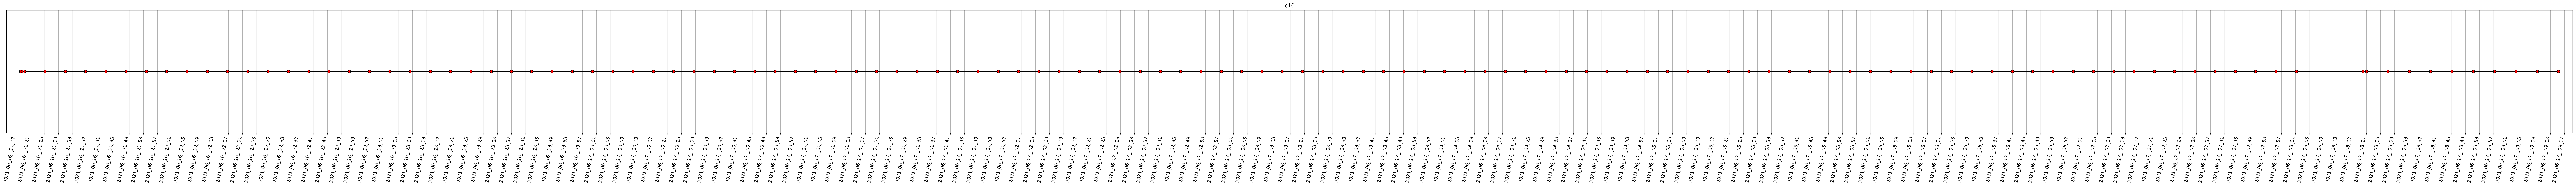

In [10]:
plot_annnotations_timestamps(annotation['c10'], title='c10')

Start date: 2021-03-25 16:18:36
End date: 2021-04-29 08:47:09


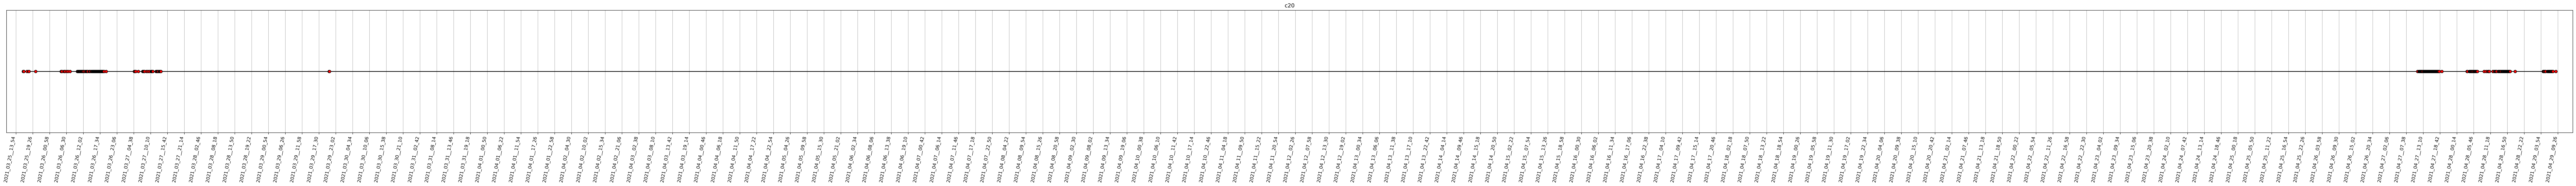

In [11]:
plot_annnotations_timestamps(annotation['c20'], title='c20')

Start date: 2021-03-25 16:17:55
End date: 2021-04-27 13:58:54


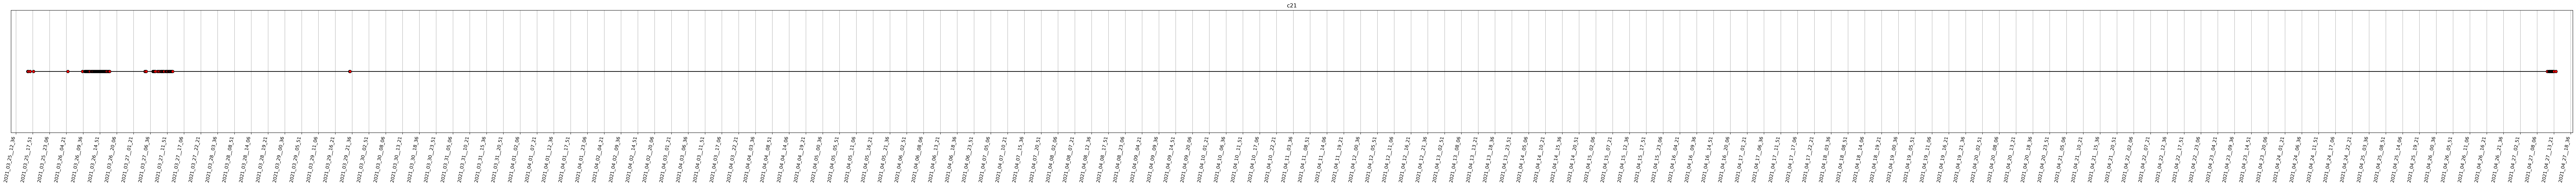

In [12]:
plot_annnotations_timestamps(annotation['c21'], title='c21')

Start date: 2021-03-25 17:17:58.329000
End date: 2021-03-29 22:56:59.440000


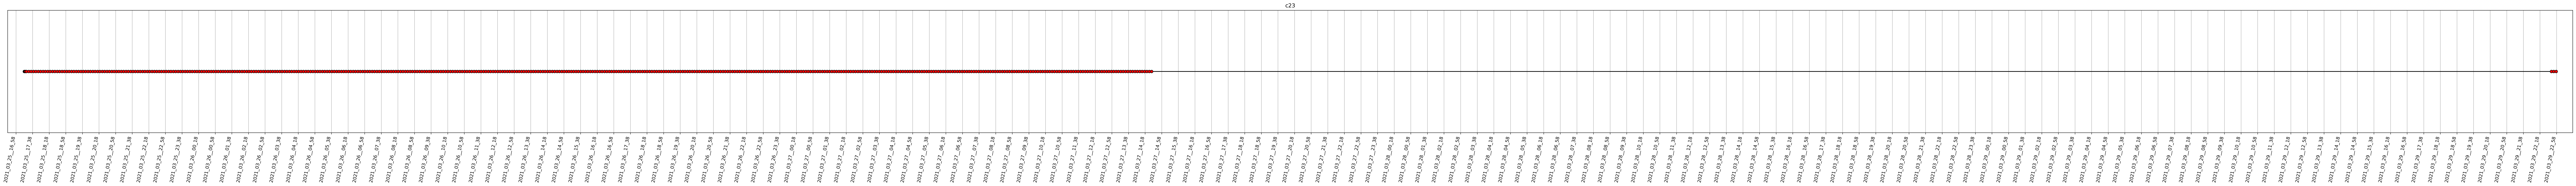

In [13]:
plot_annnotations_timestamps(annotation['c23'], title='c23')

# Let's sample some image pairs and do image comparison

## Generate random combinations of 2 images

In [3]:
%matplotlib inline

import random
import itertools

def generate_img_pairs_names(dataset, num_pairs_each_seq):
    imgs_pairs_names = []
    for _, annotations in dataset.items():
        imgs_pairs = random.choices(list(itertools.combinations(range(len(annotations)), 2)), k=num_pairs_each_seq)
        names = [[annotations[img_index].image_name for img_index in i] for i in imgs_pairs]
        imgs_pairs_names.extend(names)

    return imgs_pairs_names

num_sampled = 1000

imgs_pairs_names = generate_img_pairs_names(annotation, num_sampled)

## Save the list as file

In [18]:
import json

json.dump(imgs_pairs_names, open('sampled_pairs.json', 'w'))

## Load the image pairs back (to reproduce the results)

In [20]:
imgs_pairs_names = json.load(open('sampled_pairs.json'))

## Let's compare the image pairs and plot the results of the score

## Because we don't know the optimal parameters values, let's set them both to 0

In [22]:
img_name_to_annotation_map = {s.image_name: s for cam_id in annotation.keys() for s in annotation[cam_id]}

Text(0.5, 1.0, 'gb_ks: 0.0; min_ca: 0.0')

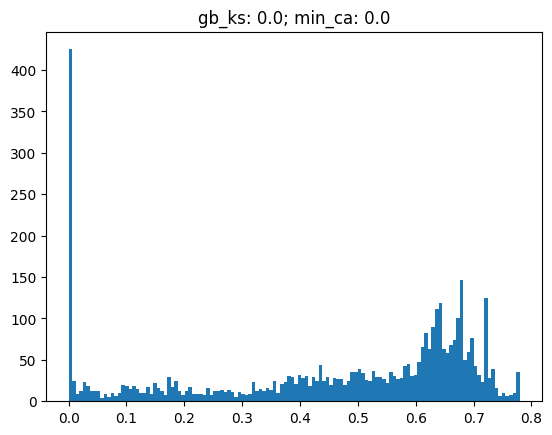

In [23]:
from similar_frames_remover.img_processing import create_caching_load_preprocess, get_min_area_img_size
from similar_frames_remover.similar_frames_remover import compare_imgs

unique_sampled_imgs_names = set()
for img_seq in zip(*imgs_pairs_names):
    unique_sampled_imgs_names.update(img_seq)

sampled_annotation = [img_name_to_annotation_map[i_name] for i_name in unique_sampled_imgs_names]

min_img_size = get_min_area_img_size(sampled_annotation)

load_preprocess_func = create_caching_load_preprocess()

scores = []
thresholded_diffs = []

for p in imgs_pairs_names:
    imgs = [load_preprocess_func(img_name, DATASET_ROOT_DIR, min_img_size, None) for img_name in p]
    score, _, thresholded_diff = compare_imgs(imgs[0], imgs[1], 0.0)

    scores.append(score)
    thresholded_diffs.append(thresholded_diff)

plt.hist(scores, bins=128)
plt.title(f'gb_ks: {0.0}; min_ca: {0.0}')

## Let's study the cases. For this, let's save matching results as joint images

In [24]:
import cv2
import os

def generate_match_res_img(img_names, thr_diff, gblur_ks_r, dataset_dir, img_size):
    imgs = [load_preprocess_func(i_name, dataset_dir, img_size, gblur_ks_r) for i_name in img_names]

    imgs_to_save = np.hstack(imgs)

    thr_diff = cv2.resize(thr_diff, [imgs_to_save.shape[1], imgs_to_save.shape[1] * thr_diff.shape[0] // thr_diff.shape[1]])
    
    imgs_to_save = np.vstack([imgs_to_save, thr_diff])

    return imgs_to_save


scores_imgs_pairs_diff = zip(scores, imgs_pairs_names, thresholded_diffs)

save_results_dir = f'results_gb_ks_{0.0}_min_ca_{0.0}__'
os.makedirs(save_results_dir, exist_ok=True)


for score_tuple in sorted(scores_imgs_pairs_diff, key=lambda e: e[0])[::10]:
    (score, img_names, thr_diff) = score_tuple

    img = generate_match_res_img(img_names, thr_diff, None, DATASET_ROOT_DIR, min_img_size)

    cv2.imwrite(os.path.join(save_results_dir, f'{score:.6f}={"=".join(img_names)}=.png'), 
                img)

In [25]:
gblur_half_size_ratio=0.0075
min_contour_area_ratio = 0.0125

## Let's analyze results

### Pairs with lower score values are very similar
![](results_gb_ks_0.0_min_ca_0.0/0.000000_c10-1623873919212.png_c10-1623891108345.png_.png)
### Pairs with higher score values are very distinct
![](results_gb_ks_0.0_min_ca_0.0/0.779015_c10-1623906923570.png_c10-1623891451921.png_.png)

### So, the metric can distinguish between the similar and distinct images

## But there are some hard examples
### Images are almost the same, but the metric is 0.411777

![](samples_no_filtering/0.411777_c21_2021_03_26__12_44_12.png_c21_2021_03_27__10_13_46.png_.png)

## And this pair is for sure different but the metric is relatevely low 0.132955

![](samples_no_filtering/0.132955_c20_2021_04_27__11_58_54.png_c20_2021_04_27__11_47_19.png_.png)

## Let's take these hard examples, label them as "the same images" or "different images" and tune the parameters of the algorithm to better distinct these situations 

### Let's copy the hard examples debug images to the separate directory and parse the names to get the hard pairs

In [26]:
chosen_samples_pairs_dir = 'samples_no_filtering'

chosen_img_pairs_names = []

for fname in sorted(os.listdir(chosen_samples_pairs_dir)):
    splits = fname.split('.png_')
    chosen_img_pairs_names.append((splits[0].split('_', 1)[1], splits[1]))

In [27]:
chosen_img_pairs_names

[('c10-1623897642421', 'c10-1623897298581'),
 ('c10-1623901080202', 'c10-1623903829982'),
 ('c20_2021_03_26__10_21_25', 'c20_2021_03_26__10_49_59'),
 ('c23-1616734217166', 'c23-1616817769833'),
 ('c23-1616795535932', 'c23-1617050734758'),
 ('c21_2021_03_26__12_15_39', 'c21_2021_03_26__13_12_45'),
 ('c23-1616745522905', 'c23-1616751004843'),
 ('c23-1616783214920', 'c23-1616714722717'),
 ('c20_2021_04_27__11_58_54', 'c20_2021_04_27__11_47_19'),
 ('c10-1623871512458', 'c10-1623901423986'),
 ('c21_2021_04_27__13_07_29', 'c21_2021_04_27__13_24_38'),
 ('c21_2021_03_26__16_44_04', 'c21_2021_03_26__16_26_56'),
 ('c20_2021_04_27__12_04_37', 'c20_2021_04_27__13_01_45'),
 ('c21_2021_03_27__10_42_18', 'c21_2021_03_26__10_55_43'),
 ('c21_2021_03_26__11_41_23', 'c21_2021_03_27__09_10_59'),
 ('c21_2021_03_26__12_44_12', 'c21_2021_03_27__10_13_46'),
 ('c21_2021_03_27__11_39_24', 'c21_2021_03_26__11_29_58')]

### Let's label image pairs, there the iamges are totally different

In [28]:
significantly_different_pairs = {('c23-1616795535932', 'c23-1617050734758'), 
                                 ('c20_2021_04_27__11_58_54', 'c20_2021_04_27__11_47_19'),
                                 ('c21_2021_04_27__13_07_29', 'c21_2021_04_27__13_24_38'),
                                 ('c21_2021_03_26__16_44_04', 'c21_2021_03_26__16_26_56'),
                                 ('c20_2021_04_27__12_04_37', 'c20_2021_04_27__13_01_45'),
                                }

## It looks like for significat portion of hard cases small differences on floor texture gives us the high score of difference
## Applying gaussian blur should reduce this effect

## So, let's first find the better gaussian blur parameter

In [ ]:
from collections import defaultdict

scores_data_gb = defaultdict(list)

gaussian_blur_ks_r = [0.0] + np.logspace(-2.7, -1, num=50).tolist()


for gb_ks_r in gaussian_blur_ks_r:
    for p in chosen_img_pairs_names:
        imgs = [load_preprocess_func(img_name, DATASET_ROOT_DIR, min_img_size, gb_ks_r) for img_name in p]
        score, _, thresholded_diff = compare_imgs(imgs[0], imgs[1], 0.0)
        
        scores_data_gb[p].append(score)

('c23-1616795535932', 'c23-1617050734758') 0.047657214506172836
('c20_2021_04_27__11_58_54', 'c20_2021_04_27__11_47_19') 0.13295476466049383
('c21_2021_04_27__13_07_29', 'c21_2021_04_27__13_24_38') 0.15900294174382715
('c21_2021_03_26__16_44_04', 'c21_2021_03_26__16_26_56') 0.16377387152777778
('c20_2021_04_27__12_04_37', 'c20_2021_04_27__13_01_45') 0.16851731288580246


(0.0, 0.02)

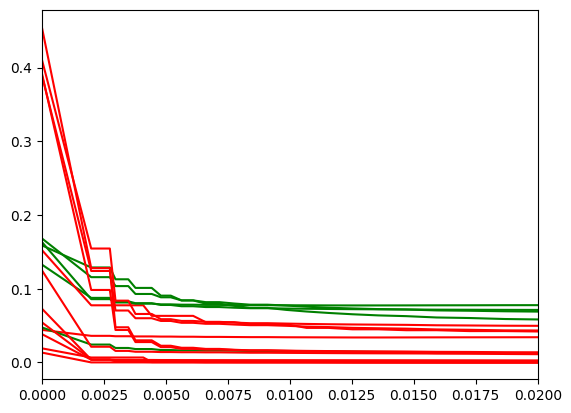

In [ ]:
%matplotlib inline

for img_names_pair, scores in scores_data_gb.items():
    plt.plot(gaussian_blur_ks_r, scores, color='green' if img_names_pair in significantly_different_pairs else 'red')
    if img_names_pair in significantly_different_pairs:
        print(img_names_pair, scores[0])

plt.xlim(0, 0.02)

### As we can see, at some value of gaussian blur size we see the separation between green different images comparison score and red same. So, the optimal value seems to be 0.0075

### Now, let's use this value for gaussian blur and tune the parameter of minimal contour area

In [ ]:
from collections import defaultdict

scores_data_mca = defaultdict(list)

mca_ratio_values = [0.0] + np.logspace(-8, -1, num=50).tolist()

for mca_val in mca_ratio_values:
    for p in chosen_img_pairs_names:
        imgs = [load_preprocess_func(img_name, DATASET_ROOT_DIR, min_img_size, 0.0075) for img_name in p]
        score, _, thresholded_diff = compare_imgs(imgs[0], imgs[1], mca_val)
        
        scores_data_mca[p].append(score)

('c23-1616795535932', 'c23-1617050734758') 0.01597511574074074
('c20_2021_04_27__11_58_54', 'c20_2021_04_27__11_47_19') 0.07431495949074074
('c21_2021_04_27__13_07_29', 'c21_2021_04_27__13_24_38') 0.07683714313271604
('c21_2021_03_26__16_44_04', 'c21_2021_03_26__16_26_56') 0.07785807291666667
('c20_2021_04_27__12_04_37', 'c20_2021_04_27__13_01_45') 0.07998987268518519


(0.0, 0.02)

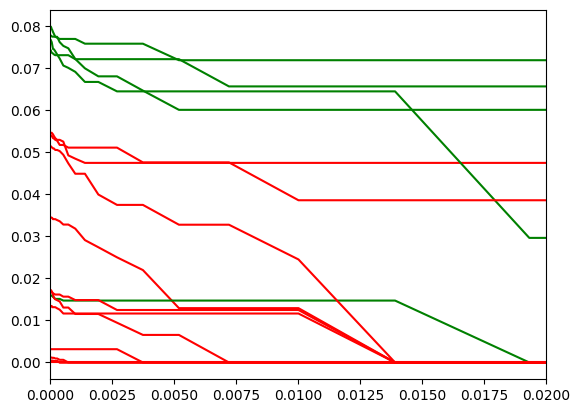

In [ ]:
%matplotlib inline

for img_names_pair, scores in scores_data_mca.items():
    plt.plot(mca_ratio_values, scores, color='green' if img_names_pair in significantly_different_pairs else 'red')
    if img_names_pair in significantly_different_pairs:
        print(img_names_pair, scores[0])

# plt.xscale('log')
plt.xlim(0, 0.02)

### As we can see, value around 0.0125 gives us some margin between ""same" and "different" comparisons. So, let's use it

# Suggested solution of the problem

Now, having better understanding of the data and how the score behaves, we can desing the algorithm to solve the problem:

1. Sort samples in timestamp ascending order for each camera
2. Remove subsequent similar frames using the image comparison method and the established value of parameters
3. For the remaining images in the sequence, apply DBSCAN clusterisation using value of score as distance between samples and established value of minimal contour area as epsilon. The clusterisation finds other similar non-sunsequent samples, which we should remove

# Ideas to improve data collection
* use the similarity estimation during the collection
* save the frames according to the similarity, and not with regular intervals. Because it's parking lots, people spend there not a lot of time, meaning 5 min interval could be too big and we miss important frames
* use weather contions as additional information
* add GPS location of the site to be able to get information about weather and daylight intensity
* record video instead of photos with using diff-based video encoders and extract key frames or estimate diff to get the frames with high diff values